# Basic use of the relative feature tightness measure

Using 25 000 structures for ChEMBL, and 25 000 from ZINC, against PMI profiles of ChEMBL and ZINC individually, and also against pKL divergence profile between ChEMBL and ZINC profile.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv

from fip import profiles

## Dataset prep

In [2]:
DATASET_NAME = 'ChEMBL28'
DATASET_LINK = '../../scratch/data/chembl_28/chembl_compounds_activities_features.csv'
OUTPUT_FIGURE_PATH = '../../scratch/data/chembl_28/pix'

FEATURES_NAME = 'ECFP1-like substructures'
COOCCURRENCE_MX_LINK = '../../scratch/data/chembl_28/ec_fragments_r1_coomx.csv'
COOCCURRENCE_MX_VECTOR_COUNT = 2066376

MINIMAL_COOCCURRENCE_CUTOFF = 100  # How many co-occurrences are needed to start tracking the relation

REFERENCE_DATASET_NAME = 'ZINC_DM'
REFERENCE_DATASET_LINK = '../../scratch/data/zinc_dark_matter/zinc_dm_in_stock_features.csv'
REFERENCE_COOCCURRENCE_MX_LINK = '../../scratch/data/zinc_dark_matter/zinc_dm_in_stock_ec_fragments_r1_coomx.csv'
REFERENCE_COOCCURRENCE_MX_VECTOR_COUNT = 5063486

# Derived from primary dataset, adjusted for size difference
REFERENCE_MINIMAL_COOCCURRENCE_CUTOFF = int(MINIMAL_COOCCURRENCE_CUTOFF * 
                                            (REFERENCE_COOCCURRENCE_MX_VECTOR_COUNT /
                                             COOCCURRENCE_MX_VECTOR_COUNT))

DATASET_SAMPLE_SIZE = 1000

### Making feature co-occurrence probability profiles

In [3]:
probability_profile = profiles.CooccurrenceProbabilityProfile.from_cooccurrence_profile(
    profiles.CooccurrenceProfile.from_dataframe(
        pd.read_csv(COOCCURRENCE_MX_LINK),
        min_cutoff_value=MINIMAL_COOCCURRENCE_CUTOFF,
        vector_count=COOCCURRENCE_MX_VECTOR_COUNT))
probability_profile.df

value
feature1   feature2                 
C=O        C=O              0.689240
           Cc(c)c           0.302402
           c-n(c)n          0.018186
           c=O              0.058172
           cC               0.132594
...                              ...
N=c([nH])n cc(c)Cl          0.000068
CCS        cN=S             0.000072
cn(c)n     nc(-n)[nH]       0.000273
CC(N)=O    cS(F)(F)(F)(F)F  0.000051
CC(F)(F)F  nc(-n)[nH]       0.000085

[47478 rows x 1 columns]

In [4]:
reference_probability_profile = profiles.CooccurrenceProbabilityProfile.from_cooccurrence_profile(
    profiles.CooccurrenceProfile.from_dataframe(
        pd.read_csv(REFERENCE_COOCCURRENCE_MX_LINK),
        min_cutoff_value=REFERENCE_MINIMAL_COOCCURRENCE_CUTOFF,
        vector_count=REFERENCE_COOCCURRENCE_MX_VECTOR_COUNT))
reference_probability_profile.df

value
feature1 feature2          
CCN      CCN       0.499327
         CCO       0.163191
         COC       0.145833
         Cn        0.027918
         Cn(n)n    0.000510
...                     ...
CC(c)n   cSc       0.000302
         cc(o)S    0.000152
C=C(C)N  cc(-n)s   0.000053
CN=c     cc(-n)s   0.000058
N=c(n)s  cc(-n)s   0.000058

[38277 rows x 1 columns]

### Making feature pointwise mutual information profiles

In [5]:
pmi_profile = profiles.PointwiseMutualInformationProfile.from_cooccurrence_probability_profile(
    probability_profile)
pmi_profile.df

value
feature1   feature2                 
C=O        C=O              0.000000
           Cc(c)c           0.336752
           c-n(c)n         -0.021437
           c=O             -0.350960
           cC              -0.038451
...                              ...
N=c([nH])n cc(c)Cl          1.755450
CCS        cN=S             2.678707
cn(c)n     nc(-n)[nH]       4.683056
CC(N)=O    cS(F)(F)(F)(F)F  0.540092
CC(F)(F)F  nc(-n)[nH]       2.898813

[47478 rows x 1 columns]

In [6]:
reference_pmi_profile = profiles.PointwiseMutualInformationProfile.from_cooccurrence_probability_profile(
    reference_probability_profile)
reference_pmi_profile.df

value
feature1 feature2          
CCN      CCN       0.000000
         CCO       0.139260
         COC       0.186709
         Cn        0.069478
         Cn(n)n   -0.508853
...                     ...
CC(c)n   cSc       2.488432
         cc(o)S    3.156343
C=C(C)N  cc(-n)s   0.589271
CN=c     cc(-n)s   1.948431
N=c(n)s  cc(-n)s   1.921099

[38277 rows x 1 columns]

### Making feature pointwise KL divergence profile between ChEMBL and ZINC

In [7]:
difference_pkld_profile = profiles.PointwiseKLDivergenceProfile.from_cooccurrence_probability_profiles(
    probability_profile, reference_probability_profile)
difference_pkld_profile.df

value
feature1 feature2          
C=O      C=O      -0.195532
         Cc(c)c   -0.042577
         c-n(c)n  -0.604856
         c=O      -0.613486
         cC       -1.073105
...                     ...
CC(c)n   cSc      -9.286288
         cc(o)S   -8.291935
C=C(C)N  cc(-n)s  -6.762255
CN=c     cc(-n)s  -6.906645
N=c(n)s  cc(-n)s  -6.911544

[54003 rows x 1 columns]

### Sampling structures from ChEMBL and ZINC datasets

In [8]:
chembl_samples = pd.read_csv(DATASET_LINK).sample(DATASET_SAMPLE_SIZE)
chembl_samples.set_index('molregno', inplace=True)
chembl_samples.rename({'canonical_smiles': 'smiles'}, axis=1, inplace=True)
chembl_samples['source'] = 'ChEMBL'
chembl_samples

,smiles,chembl_activities,ec_fragments_r1,ec_fragments_r2,ec_fragments_r3,brics_fragments,source
molregno,,,,,,,
1090583,COc1ccc(S(=O)(=O)N2CCC3(CC2)OCCN3S(=O)(=O)c2cc...,NaN,cc(c)O | CC(C)(N)O | COC | ccc | CCN | cS(N)(=...,COCCN | cc(s)S(=O)(=O)N(C)C | CCOC(C)(C)N | CN...,cS(=O)(=O)N1CCOC12CCNCC2 | cc(s)S(=O)(=O)N1CCO...,[5*]N1CCC2(CC1)OCCN2[5*] [12*]S(=O)(=O)c1cccs1...,ChEMBL
685806,COc1cc2c(NC3CCN(C)CC3)nc(N3CCCN(C)CC3)nc2cc1OC...,"Histone-lysine N-methyltransferase, H3 lysine-...",cc(c)O | CN | cc(n)N | ccc | CCN | CN(C)C | cN...,CCCN(C)C | cc(c)nc(n)N | cc(c)OCC | cc(O)cc(c)...,cc(n)NC1CCNCC1 | cc1ccc(OC)c(OC)c1 | CCCN1CCCC...,[15*]C1CCN(C)CC1 [5*]N[5*] [14*]c1nc([14*])c2c...,ChEMBL
1493114,CCOC(=O)CSc1nc2cc(-n3nc(C)n(C(F)F)c3=O)c(Cl)cc2s1,NaN,CC | COC | Cc(n)n | nc(n)=O | cc(c)Cl | c=O | ...,cn(C)c(C)nn | cnc(SC)sc | c-n(c)nc(C)n | cSCC(...,cn(n)-c1ccc(s)cc1Cl | COC(=O)CSc(n)s | cnn(-c1...,[9*]n1nc(C)n([9*])c1=O [14*]c1nc2cc([16*])c(Cl...,ChEMBL
1406147,C[C@@H](CO)N1C[C@@H](C)[C@@H](CN(C)C(=O)Nc2ccc...,NaN,cc(c)O | CN | COC | NC(N)=O | CCN | CN(C)C | O...,ccc(cc)NS | CCCC(C)O | CC(N)CO | cS(=O)(=O)Nc(...,CN(C)CC(C)C(CN)OC | CNc1ccc(O)c(OC)c1 | ccc(C(...,[12*]S(=O)(=O)c1ccc(Cl)cc1 [16*]c1ccc2c(c1)OCO...,ChEMBL
333700,COc1cc(CN2C(=O)N(Cc3ccc(O)c(OC)c3)N(C(=O)COc3c...,Human immunodeficiency virus 1,cc(c)O | NC(N)=O | ccc | CCN | cc(c)C | CN(C)C...,CN(C)N(CC)C(C)=O | CCOc(c)c | cCN(C(N)=O)C(C)C...,c1ccccc1 | CCOc1ccccc1 | CN(N)Cc1cccc(O)c1 | c...,[16*]c1ccc(O)c([16*])c1 [8*]C[8*] [16*]c1ccccc...,ChEMBL
...,...,...,...,...,...,...,...
2204751,O=C1NCC[C@H]1C[C@H](NC(=O)[C@H](CC1CCCCC1)NS(=...,NaN,C=O | ccc | CCN | cS(N)(=O)=O | CCC | CC(O)S |...,c-c(c)ccc | CNC(=O)C(C)C | CC(N)CC(C)C | cc(c)...,c-c1ccc(S(N)(=O)=O)cc1 | cc(c)-c1ccccc1 | CC(N...,[1*]C(=O)C([4*])C[8*] [16*]c1ccccc1 [4*]C(C[8*...,ChEMBL
452067,CCOC(=O)c1c(-c2ccc(F)cc2)cc(-c2ccccc2)nc1N1CCCCC1,NaN,COC | cc(n)N | ccc | cC(=O)O | CCN | cc(c)F | ...,c-c(c)ccc | cN(C)CCC | cC(=O)OCC | Cc(c)c(nc)N...,Fc1ccccc1 | c1ccccc1 | c-c1cc(N)nc(-c(cc)cc)c1...,[16*]c1ccc(F)cc1 [1*]C([6*])=O [14*]c1cc([16*]...,ChEMBL
748434,Cc1ccc(NC(=S)N2CCN(S(=O)(=O)c3ccccc3)CC2)cc1C,NaN,ccc | CCN | cc(c)C | cNC | CN(C)C | cC | cS(N)...,cc(c)S(=O)(=O)N(C)C | CN(S)CCN | cc(C)cc(c)N |...,Cc1cccc(NC(N)=S)c1 | c1ccccc1 | Cc1ccccc1C | C...,[5*]NC(=S)N1CCN([5*])CC1 [16*]c1ccc(C)c(C)c1 [...,ChEMBL


In [9]:
zinc_samples = pd.read_csv(REFERENCE_DATASET_LINK).sample(DATASET_SAMPLE_SIZE)
zinc_samples.set_index('id', inplace=True)
zinc_samples['source'] = 'ZINC'
zinc_samples

,smiles,ec_fragments_r1,ec_fragments_r2,ec_fragments_r3,brics_fragments,source
id,,,,,,
ZINC000153598397,Cc1ccc2c(c1)[C@H](NC(=O)N1CC(Oc3ccc(C#N)cc3)C1...,C=O | cC | CCO | NC(N)=O | cc(c)C | Cc(c)c | c...,cc(C)cc(c)C | ccc(C#N)cc | NC(=O)N1CCC1 | CN1C...,cC(C)NC(=O)N1CCC1 | Cc1cccc(C)c1 | ccc(cc)OC1C...,[3*]O[3*] [5*]N1CC([15*])C1 [16*]c1ccc(C#N)cc1...,ZINC
ZINC000585266805,C[C@@]1(CCCNC(=O)c2ccc(Cl)cc2)Oc2ccc(CCC(=O)O)...,C=O | CC(C)C | cc(c)C | cCC | CC(C)(C)O | cc(c...,cOC(C)(CC)C(C)C | cccc(c)Cl | cc(C)cc(c)C | CC...,cc1cC(O)C(CC)C(C)(CCC)O1 | ccc1c(c)OC(C)(C)C2C...,[8*]CCC(=O)O [5*]N[5*] [13*]C1(C)Oc2ccc([16*])...,ZINC
ZINC000002395296,O=C(Cn1c2c(sc1=O)[C@@H]1c3ccccc3OC[C@H]1CS2)Nc...,C=O | CC(C)C | cc(c)C | CC(N)=O | cc(c)O | cn(...,cccc(c)Cl | cn(c)CC(N)=O | cSCC(C)C | cc(c)C(c...,CC(=O)Nc1cccc(Cl)c1 | Cc1ccccc1 | COc1ccccc1C ...,[1*]C(=O)C[8*] [5*]N[5*] [16*]c1ccc(Cl)c(Cl)c1...,ZINC
ZINC000584595539,O=C(O)[C@@H](c1ccc(-c2cncc(C(F)(F)F)c2)c(F)c1)...,C=O | CC(C)C | CF | cc(c)F | cC(F)(F)F | CC(c)...,ccc(cn)-c(c)c | cncc(c)C | cC(C)C(=O)O | CCCC(...,c-c1ccc(C(C)C)cc1 | CC(c)C1CCCC1 | CC(C)C(C(=O...,[16*]c1cncc([16*])c1 [8*]C(F)(F)F [16*]c1ccc([...,ZINC
ZINC000100307864,COc1ccc(CCN2C(=O)C[C@@H](C(=O)Nc3ccc(F)cc3)S/C...,C=O | cc(c)C | cc(c)F | cN=C | cCC | CC(N)=O |...,cccc(c)Cl | ccc(OC)c(c)O | ccc(cc)CC | CN(C)C(...,CCC(SC)C(=O)Nc(c)c | CC(=O)Nc1ccccc1 | CC1CC(=...,[3*]OC [5*]N[5*] [10*]N1C(=O)CC([13*])SC1=Nc1c...,ZINC
...,...,...,...,...,...,...
ZINC000022620654,CCOC(=O)c1cc(Cc2ccccc2)sc1NC(=O)CC(C)C,C=O | CC(C)C | CCO | cc(c)C | cc(N)s | COC | c...,Cc(c)cc(C)s | cc(C)sc(c)N | cCc(cc)sc | COCC |...,Cc1cc(Cc(c)c)sc1N | cc(s)Cc1ccccc1 | CNc1sc(C)...,[14*]c1cc([16*])c([14*])s1 [3*]O[3*] [8*]C[8*]...,ZINC
ZINC000409032533,CCOC(=O)C1=C(C)N=c2s/c(=C\c3ccc(O)cc3O)c(=O)n2...,cc(c)C | C=O | cc(n)=O | cO | C=c(c)s | C=C(C)...,C=C(C)N=c(n)s | CCOc(c)c | c=Cc(cc)c(c)O | cc(...,CC(=C)C(c1cccc(O)c1)n(c)c | CC1=CN=c2sc(=C)c(=...,[3*]O[3*] [4*]CC [3*]OC [1*]C(=O)C1=C(C)N=c2sc...,ZINC
ZINC000028290011,COc1ccc([C@H](CNC(=O)c2cc(=O)c3c(C)cc(C)cc3o2)...,C=O | cC | cc(c)C | cc(c)O | cC(N)=O | coc | C...,cc(C)cc(c)C | Cc(o)cc(c)=O | ccc(=O)c(c)c | CC...,Cc1cccc2occc(=O)c12 | CNCC(c(cc)cc)N(CC)CC | C...,[3*]OC [5*]N[5*] [14*]c1cc(=O)c2c(C)cc(C)cc2o1...,ZINC


In [10]:
joint_samples = pd.concat((chembl_samples, zinc_samples), ignore_index=True)

# Unpacking the pre-computed radius 1 fragments
joint_samples['ec_fragments_r1'] = joint_samples['ec_fragments_r1'].apply(lambda x: x.split(' | '))
joint_samples

,smiles,chembl_activities,ec_fragments_r1,ec_fragments_r2,ec_fragments_r3,brics_fragments,source
0,COc1ccc(S(=O)(=O)N2CCC3(CC2)OCCN3S(=O)(=O)c2cc...,NaN,"[cc(c)O, CC(C)(N)O, COC, ccc, CCN, cS(N)(=O)=O...",COCCN | cc(s)S(=O)(=O)N(C)C | CCOC(C)(C)N | CN...,cS(=O)(=O)N1CCOC12CCNCC2 | cc(s)S(=O)(=O)N1CCO...,[5*]N1CCC2(CC1)OCCN2[5*] [12*]S(=O)(=O)c1cccs1...,ChEMBL
1,COc1cc2c(NC3CCN(C)CC3)nc(N3CCCN(C)CC3)nc2cc1OC...,"Histone-lysine N-methyltransferase, H3 lysine-...","[cc(c)O, CN, cc(n)N, ccc, CCN, CN(C)C, cNC, CC...",CCCN(C)C | cc(c)nc(n)N | cc(c)OCC | cc(O)cc(c)...,cc(n)NC1CCNCC1 | cc1ccc(OC)c(OC)c1 | CCCN1CCCC...,[15*]C1CCN(C)CC1 [5*]N[5*] [14*]c1nc([14*])c2c...,ChEMBL
2,CCOC(=O)CSc1nc2cc(-n3nc(C)n(C(F)F)c3=O)c(Cl)cc2s1,NaN,"[CC, COC, Cc(n)n, nc(n)=O, cc(c)Cl, c=O, cc(c)...",cn(C)c(C)nn | cnc(SC)sc | c-n(c)nc(C)n | cSCC(...,cn(n)-c1ccc(s)cc1Cl | COC(=O)CSc(n)s | cnn(-c1...,[9*]n1nc(C)n([9*])c1=O [14*]c1nc2cc([16*])c(Cl...,ChEMBL
3,C[C@@H](CO)N1C[C@@H](C)[C@@H](CN(C)C(=O)Nc2ccc...,NaN,"[cc(c)O, CN, COC, NC(N)=O, CCN, CN(C)C, OCO, c...",ccc(cc)NS | CCCC(C)O | CC(N)CO | cS(=O)(=O)Nc(...,CN(C)CC(C)C(CN)OC | CNc1ccc(O)c(OC)c1 | ccc(C(...,[12*]S(=O)(=O)c1ccc(Cl)cc1 [16*]c1ccc2c(c1)OCO...,ChEMBL
4,COc1cc(CN2C(=O)N(Cc3ccc(O)c(OC)c3)N(C(=O)COc3c...,Human immunodeficiency virus 1,"[cc(c)O, NC(N)=O, ccc, CCN, cc(c)C, CN(C)C, cO...",CN(C)N(CC)C(C)=O | CCOc(c)c | cCN(C(N)=O)C(C)C...,c1ccccc1 | CCOc1ccccc1 | CN(N)Cc1cccc(O)c1 | c...,[16*]c1ccc(O)c([16*])c1 [8*]C[8*] [16*]c1ccccc...,ChEMBL
...,...,...,...,...,...,...,...
1995,CCOC(=O)c1cc(Cc2ccccc2)sc1NC(=O)CC(C)C,NaN,"[C=O, CC(C)C, CCO, cc(c)C, cc(N)s, COC, cC(=O)...",Cc(c)cc(C)s | cc(C)sc(c)N | cCc(cc)sc | COCC |...,Cc1cc(Cc(c)c)sc1N | cc(s)Cc1ccccc1 | CNc1sc(C)...,[14*]c1cc([16*])c([14*])s1 [3*]O[3*] [8*]C[8*]...,ZINC
1996,CCOC(=O)C1=C(C)N=c2s/c(=C\c3ccc(O)cc3O)c(=O)n2...,NaN,"[cc(c)C, C=O, cc(n)=O, cO, C=c(c)s, C=C(C)N, N...",C=C(C)N=c(n)s | CCOc(c)c | c=Cc(cc)c(c)O | cc(...,CC(=C)C(c1cccc(O)c1)n(c)c | CC1=CN=c2sc(=C)c(=...,[3*]O[3*] [4*]CC [3*]OC [1*]C(=O)C1=C(C)N=c2sc...,ZINC
1997,COc1ccc([C@H](CNC(=O)c2cc(=O)c3c(C)cc(C)cc3o2)...,NaN,"[C=O, cC, cc(c)C, cc(c)O, cC(N)=O, coc, Cc(c)o...",cc(C)cc(c)C | Cc(o)cc(c)=O | ccc(=O)c(c)c | CC...,Cc1cccc2occc(=O)c12 | CNCC(c(cc)cc)N(CC)CC | C...,[3*]OC [5*]N[5*] [14*]c1cc(=O)c2c(C)cc(C)cc2o1...,ZINC
1998,CCCNC(=O)[C@H](C)N(Cc1cccc(C)c1)C(=O)COc1ccc(C...,NaN,"[CC(C)N, cC, cC(C)(C)C, C=O, cc(c)C, CCO, CN(C...",CCNC(C)=O | cc(C)cc(c)C | cc(c)C(C)(C)C | CN(C...,cCN(C(=O)COc)C(C)C | cc(c)CN(C(=O)CO)C(C)C(N)=...,[1*]C(=O)C([4*])C [3*]O[3*] [5*]N([5*])[5*] [5...,ZINC


## Relative feature tightness against a PMI interrelation profile

In [ ]:
joint_samples['RFT'] = joint_samples['ec_fragments_r1'].apply(
    lambda x: difference_pkld_profile.relative_feature_divergence(x))
joint_samples

In [ ]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(joint_samples, x='RFT', hue='source')

According to the histogram, there is a visible split between Relative feature tightness distribution against the pointwise KL divergence profile between ChEMBL and ZINC datasets, based on their radius 1 fragments. Larger fragments might diverge even further.

<AxesSubplot:xlabel='RFT', ylabel='Count'>

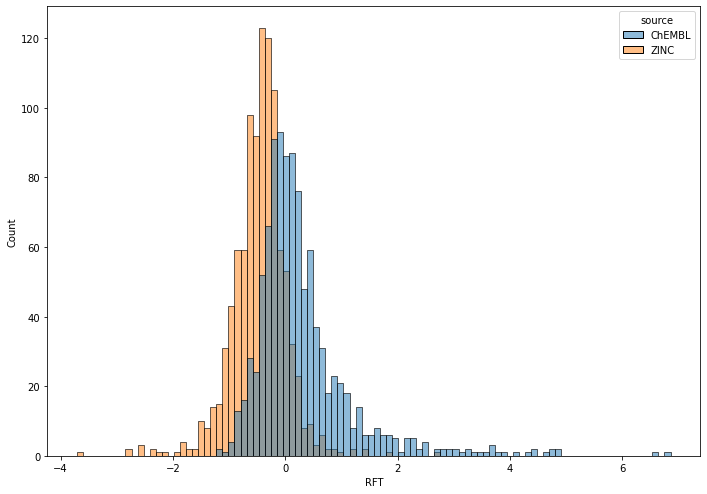

In [12]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(joint_samples, x='RFT', hue='source')

According to the histogram, there is a visible split between Relative feature tightness distribution against the pointwise KL divergence profile between ChEMBL and ZINC datasets, based on their radius 1 fragments. Larger fragments might diverge even further.